In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("C:/Users/soma2003/Desktop/market.csv",sep=';', dtype='unicode')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   BillNo      522064 non-null  object
 1   Itemname    520609 non-null  object
 2   Quantity    522064 non-null  object
 3   Date        522064 non-null  object
 4   Price       522064 non-null  object
 5   CustomerID  388023 non-null  object
 6   Country     522064 non-null  object
dtypes: object(7)
memory usage: 27.9+ MB


In [4]:
df.describe()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
count,522064,520609,522064,522064,522064,388023,522064
unique,21663,4185,690,19641,1285,4297,30
top,573585,WHITE HANGING HEART T-LIGHT HOLDER,1,31.10.2011 14:41,"1,25",17841,United Kingdom
freq,1114,2269,147848,1114,48778,7847,487622


In [5]:
print(df.isna().sum())

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64


#### rmf analysis

In [6]:
today = "2012-01-01"
today = pd.to_datetime(today)
df["Date"] = pd.to_datetime(df["Date"])
#recency
rec_table=df.groupby(['CustomerID']).agg({"Date": lambda x: ((today - x.max()).days)})
rec_table.columns=['Recency']
print(rec_table.head())

            Recency
CustomerID         
12346           347
12347            61
12349            40
12350           332
12352            94


In [7]:
#frequency
frq_table=df.drop_duplicates(['BillNo']).groupby(['CustomerID'])[['BillNo']].count()
frq_table.columns=['frequency']
frq_table.head()

,frequency
CustomerID,
12346,1
12347,7
12349,1
12350,1
12352,8


In [18]:
df["Price"] = df["Price"].str.replace(",",".")
df["Price"] = df["Price"].astype("float64")
df['Quantity']=df['Quantity'].astype("float64")
#monetary
df["Total"]=df['Price']*df['Quantity']
mon_table=df.groupby(['CustomerID'])[['Total']].sum()

In [19]:
#creating summary table
rmf_table=pd.concat([mon_table,frq_table,rec_table],axis=1)
print(rmf_table.head())

               Total  frequency  Recency
CustomerID                              
12346       77183.60          1      347
12347        4310.00          7       61
12349        1757.55          1       40
12350         334.40          1      332
12352        2506.04          8       94


In [20]:
rmf_table.describe()

,Total,frequency,Recency
count,4297.000000,4297.000000,4297.000000
mean,1993.140888,4.226902,126.545264
std,8588.143093,7.090722,115.234387
min,0.000000,1.000000,21.000000
25%,306.720000,1.000000,43.000000
50%,668.580000,2.000000,82.000000
75%,1652.580000,5.000000,183.000000
max,280206.020000,210.000000,718.000000


In [21]:
#scaling 
#why i need scaling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler=StandardScaler()
rmf_scaled=scaler.fit_transform(rmf_table)

### ML method

In [22]:

#clustering using KMeans
inertia=[]
for k in range(1,6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(rmf_scaled)
    inertia.append(kmeans.inertia_)

#### Plot

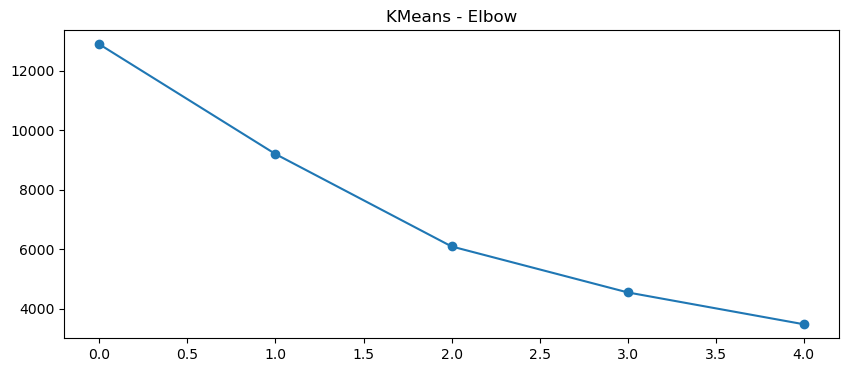

In [66]:
plt.figure(figsize = (10,4))    
plt.plot(inertia, marker = "o")
plt.title("KMeans - Elbow");

 We will use 3 clusters 

In [24]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(rmf_scaled)
rmf_table['Nr_Cluster']=(kmeans.labels_+1)

In [25]:
rmf_table.head().sort_values(by='Nr_Cluster')

,Total,frequency,Recency,Nr_Cluster
CustomerID,,,,
12347,4310.00,7,61,1
12349,1757.55,1,40,1
12352,2506.04,8,94,1
12350,334.40,1,332,2
12346,77183.60,1,347,3


In [26]:
final=rmf_table.groupby("Nr_Cluster")[['frequency','Recency','Total']].mean()

#### customer segmentation
#### 3 clusters

In [27]:
final

,frequency,Recency,Total
Nr_Cluster,,,
1,4.797228,68.634429,1913.384218
2,1.545299,281.745299,495.484189
3,58.960000,48.760000,81979.682000


In [29]:
items=list(df['Itemname'].unique())

In [30]:
print(len(items))

4186


In [31]:
items[:10]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT']

##### barchart with 3 clusters, segmentation

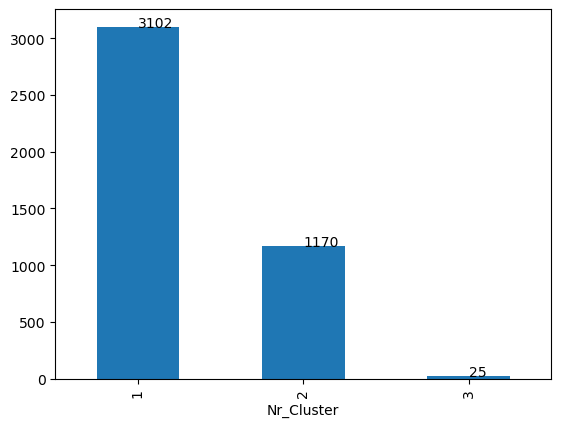

In [41]:
cluster_count=rmf_table.groupby('Nr_Cluster')['Total'].count()
cluster_count.plot(kind='bar')
for index, value in enumerate(cluster_count):
    plt.text(index,value, str(value))
plt.show()

##### basket market analysis

In [43]:
data_b = df.groupby(["BillNo", "Itemname"])[["Quantity"]].sum(
).unstack().reset_index().fillna(0).set_index("BillNo")

In [44]:
data_b.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                     0.0                     0.0                    0.0   
536366                     0.0                     0.0                    0.0   
536367                     0.0                     0.0                    0.0   
536368                     0.0                     0.0                    0.0   
536369                     0.0                     0.0                    0.0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                          0.0                       0.0   
536366                          0.0                       0.0   
536367                          0.0                       0.0   
536368                          0.0                       0.0   
536369                          0.0                       0.0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                         0.0                          0.0   
536366                         0.0                          0.0   
536367                         0.0                          0.0   
536368                         0.0                          0.0   
536369                         0.0                          0.0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                0.0                             0.0   
536366                                0.0                             0.0   
536367                                0.0                             0.0   
536368                                0.0                             0.0   
536369                                0.0                             0.0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                             0.0  ...                 0.0   
536366                             0.0  ...                 0.0   
536367                             0.0  ...                 0.0   
536368                             0.0  ...                 0.0   
536369                             0.0  ...                 0.0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                   0.0                 0.0            0.0   
536366                   0.0                 0.0            0.0   
536367                   0.0                 0.0            0.0   
536368                   0.0                 0.0            0.0   
536369                   0.0                 0.0            0.0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                    0.0                         0.0   
536366                    0.0                         0.0   
536367                    0.0                         0.0   
536368                    0.0                         0.0   
536369                    0.0                         0.0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [46]:
def one_hot_encoding(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
data_b = data_b.applymap(one_hot_encoding)

In [47]:
data_b.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                       0                       0                      0   
536366                       0                       0                      0   
536367                       0                       0                      0   
536368                       0                       0                      0   
536369                       0                       0                      0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                            0                         0   
536366                            0                         0   
536367                            0                         0   
536368                            0                         0   
536369                            0                         0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                           0                            0   
536366                           0                            0   
536367                           0                            0   
536368                           0                            0   
536369                           0                            0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                  0                               0   
536366                                  0                               0   
536367                                  0                               0   
536368                                  0                               0   
536369                                  0                               0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                               0  ...                   0   
536366                               0  ...                   0   
536367                               0  ...                   0   
536368                               0  ...                   0   
536369                               0  ...                   0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                     0                   0              0   
536366                     0                   0              0   
536367                     0                   0              0   
536368                     0                   0              0   
536369                     0                   0              0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                      0                           0   
536366                      0                           0   
536367                      0                           0   
536368                      0                           0   
536369                      0                           0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [62]:
#!pip install mlxtend

In [51]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(data_b, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values("lift", ascending = False)

C:\Users\soma2003\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [52]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
154,"((Quantity, ROSES REGENCY TEACUP AND SAUCER), ...","((Quantity, PINK REGENCY TEACUP AND SAUCER))",0.036174,0.036421,0.025485,0.704514,19.343514,0.024167,3.261000
155,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER), ...",0.036421,0.036174,0.025485,0.699728,19.343514,0.024167,3.209847
152,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.028207,0.048248,0.025485,0.903509,18.726262,0.024124,9.863609
157,"((Quantity, GREEN REGENCY TEACUP AND SAUCER))","((Quantity, PINK REGENCY TEACUP AND SAUCER), (...",0.048248,0.028207,0.025485,0.528205,18.726262,0.024124,2.059779
25,"((Quantity, GREEN REGENCY TEACUP AND SAUCER))","((Quantity, PINK REGENCY TEACUP AND SAUCER))",0.048248,0.036421,0.029939,0.620513,17.037124,0.028181,2.539160
...,...,...,...,...,...,...,...,...,...
148,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, WOODEN PICTURE FRAME WHITE FINISH))",0.108967,0.054038,0.020042,0.183924,3.403599,0.014153,1.159159
130,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.108967,0.060966,0.020338,0.186649,3.061520,0.013695,1.154524
131,"((Quantity, NATURAL SLATE HEART CHALKBOARD))","((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))",0.060966,0.108967,0.020338,0.333604,3.061520,0.013695,1.337093
80,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, JUMBO BAG RED RETROSPOT))",0.108967,0.102138,0.021873,0.200727,1.965254,0.010743,1.123348


In [57]:
ff=pd.concat([rules['antecedents'],rules['consequents'],rules['confidence']],axis=1).sort_values('confidence',ascending=False)

In [65]:
ff

,antecedents,consequents,confidence
152,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.903509
153,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.851240
24,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.822011
160,"((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...","((Quantity, JUMBO BAG RED RETROSPOT))",0.801556
138,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.774457
...,...,...,...
70,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SKULLS))",0.200097
161,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...",0.199612
42,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO BAG ALPHABET))",0.199128
130,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.186649
